In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import lsst.daf.butler as daf_butler
from lsst.obs.lsst import LsstCam, LsstTS8
import lsst.eo.pipe as eo_pipe

In [2]:
# For Run 6, we'll use the '/repo/ir2' butler repository.  We've analyzed the Run 5 data using '/repo/main'.
repo = '/repo/main'
# The shifters will run the cp_pipe and eo_pipe pipelines using the lsstccs group account.  For our setups,
# environment variables will be used to specify the runs to analyze and the weekly version of the LSST stack
# to run.  The collection names of the outputs will be composed of the operator, run number, and weekly version.
operator = 'lsstccs'
acq_run = '13162'  # This is a B-protocol run.
weekly = 'w_2023_22'

In [3]:
# We use the collection naming scheme to find all of the chained collections for an eo_pipe analysis of 
# the specified run.  For our dataset queries, we'll use these collections.
butler = daf_butler.Butler(repo)
collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections:
    print(item)

u/lsstccs/eo_bias_stability_parallel_overscan_13162_w_2023_22
u/lsstccs/eo_read_noise_13162_w_2023_22
u/lsstccs/eo_dark_current_13162_w_2023_22
u/lsstccs/eo_raft_amp_correlations_13162_w_2023_22
u/lsstccs/eo_eper_13162_w_2023_22
u/lsstccs/eo_divisadero_tearing_13162_w_2023_22
u/lsstccs/eo_raft_calib_mosaics_13162_w_2023_22
u/lsstccs/eo_bright_defects_13162_w_2023_22
u/lsstccs/eo_persistence_13162_w_2023_22
u/lsstccs/eo_bias_stability_13162_w_2023_22
u/lsstccs/eo_dark_defects_13162_w_2023_22
u/lsstccs/eo_raft_lambda_mosaics_13162_w_2023_22
u/lsstccs/eo_bias_stability_mean_overscan_13162_w_2023_22


In [4]:
# Several eo_pipe pipelines produce per-amp measurements for all of the CCDs in the current Camera object.
# For LSSTCam, this would include all 205 CCDs in the focal plane; for TS8, this would be the 9 CCDs in 
# the raft installed at that test stand (currently RTM-004).
#
# The `eo_pipe.get_amp_data` function will retrieve these per-amp measurements and return them as a 
# three-level dictionary, keyed by measurement quantity, CCD (labeled by R**_S for LSSTCam), and 
# amplifier data (labeled by channel name, e.g., 'C01').
#
# The '[ps]cti' quantities are measured from combined flats, so will have different values depending on the
# filter used, since combined flats a created separately for each filter combination.
amp_data = eo_pipe.get_amp_data(repo, collections)
for quantity in amp_data.keys():
    print(quantity)

read_noise
bright_columns
bright_pixels
dark_columns
dark_pixels
dark_current_95
dark_current_median
divisadero_tearing
ptc_a00
ptc_gain
ptc_noise
ptc_turnoff
('scti', 'SDSSi~ND_OD1.0')
('pcti', 'SDSSi~ND_OD1.0')
('scti', 'SDSSi')
('pcti', 'SDSSi')


In [5]:
print(amp_data['read_noise'].keys())

dict_keys(['R21_S00', 'R23_S02', 'R20_S22', 'R34_S20', 'R23_S22', 'R03_S01', 'R10_S21', 'R21_S01', 'R12_S12', 'R03_S02', 'R12_S01', 'R02_S10', 'R43_S21', 'R10_S10', 'R31_S21', 'R43_S20', 'R03_S20', 'R32_S02', 'R30_S21', 'R30_S20', 'R23_S12', 'R20_S20', 'R22_S01', 'R12_S02', 'R24_S21', 'R02_S01', 'R20_S02', 'R24_S00', 'R24_S01', 'R11_S00', 'R12_S10', 'R14_S22', 'R30_S00', 'R00_SG1', 'R10_S01', 'R01_S22', 'R31_S10', 'R04_SW1', 'R41_S20', 'R22_S22', 'R23_S00', 'R44_SW1', 'R41_S21', 'R24_S20', 'R41_S22', 'R11_S11', 'R31_S00', 'R21_S10', 'R20_S10', 'R32_S22', 'R44_SG1', 'R33_S00', 'R22_S21', 'R41_S10', 'R12_S21', 'R23_S11', 'R23_S21', 'R11_S10', 'R32_S21', 'R20_S21', 'R34_S10', 'R41_S12', 'R13_S10', 'R21_S22', 'R20_S00', 'R43_S00', 'R14_S00', 'R41_S00', 'R33_S11', 'R01_S01', 'R14_S12', 'R01_S21', 'R14_S01', 'R11_S02', 'R21_S12', 'R41_S02', 'R13_S21', 'R22_S00', 'R10_S12', 'R04_SG0', 'R42_S10', 'R42_S11', 'R34_S12', 'R44_SW0', 'R21_S21', 'R12_S00', 'R10_S00', 'R23_S01', 'R31_S12', 'R03_S11',

In [6]:
print(amp_data['read_noise']['R03_S10'].keys())

dict_keys(['C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'C01', 'C00'])


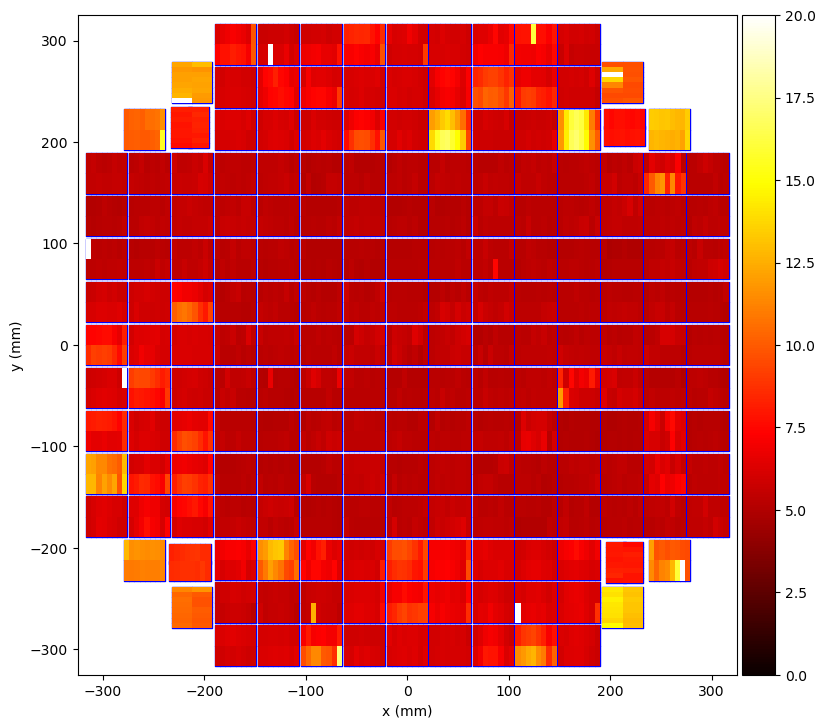

In [7]:
# These dicts of amplifier data in a format that can be used with the focal plane plotting functions in eo_pipe:
plt.figure(figsize=(9, 9))
ax = plt.gca()
eo_pipe.plotting.plot_focal_plane(ax, amp_data['read_noise'], z_range=(0, 20));

In [8]:
# Many of the eo_pipe pipelines produce other data products, mostly in the form of data frames.
# Using the dataset type names, we can retrieve these data products using the butler.
butler = daf_butler.Butler(repo, collections=collections)

dstypes = ('eo_read_noise', 'bright_defects_results', 'dark_defects_results', 'dark_current_stats',
           'divisadero_stats', 'divisadero_response', 'ptc_summary', 'eper_stats', 'linearity_results',
           'bf_stats', 'bias_stability_stats', 'cti_vs_flux', 'flat_gain_stability_stats', 
           'persistence_data')

In [9]:
# Because of how the parallelization works with LSST middleware, some of the pipeline algorithms produce
# output separate data frames for each CCD.  Other algorithms work on all of the CCDs in one process, so 
# produce a single data frame for the entire focal plane.
#
# Here we loop over the datasets and print out the .info() for the datasets that are data frames.  Some
# of the datasets return zero references since they are derived from the PTC analysis in cp_pipe, and
# that pipeline was run on the densely sampled PTC data in run 13144.
for i, dstype in enumerate(dstypes, 1):
    refs = list(set(butler.registry.queryDatasets(dstype, findFirst=True).expanded()))
    print(i, dstype, len(refs), end='  ')
    if not refs:  # No data products found for this dataset type for this run.
        print()
        continue
    ds = butler.get(refs[0])
    if isinstance(ds, pd.DataFrame):
        print(ds.info())
    print()

1 eo_read_noise 205  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   run          320 non-null    object 
 1   exposure_id  320 non-null    int64  
 2   det_name     320 non-null    object 
 3   amp_name     320 non-null    object 
 4   read_noise   320 non-null    float64
 5   median       320 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 15.1+ KB
None

2 bright_defects_results 1  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   det_name        3216 non-null   object
 1   amp_name        3216 non-null   object
 2   bright_columns  3216 non-null   int64 
 3   bright_pixels   3216 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 100.6+ KB
None

3 dark_defects

In [10]:
# Retrieve datasets associated with PTC analysis
acq_run = '13144'
butler = daf_butler.Butler(repo)
collections = butler.registry.queryCollections(f"u/{operator}/eo_*_{acq_run}_{weekly}",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections:
    print(item)

u/lsstccs/eo_bf_analysis_13144_w_2023_22
u/lsstccs/eo_ptc_plots_13144_w_2023_22
u/lsstccs/eo_linearity_plots_13144_w_2023_22
u/lsstccs/eo_cti_vs_flux_13144_w_2023_22


In [11]:
amp_data = eo_pipe.get_amp_data(repo, collections)
for quantity in amp_data.keys():
    print(quantity)

read_noise
divisadero_tearing
ptc_a00
ptc_turnoff
ptc_gain
ptc_noise
row_mean_var_slope
max_frac_dev
max_observed_signal
linearity_turnoff
bf_xcorr
bf_ycorr
bf_mean
bf_slope_x
bf_slope_x_err
bf_slope_y
bf_slope_y_err


In [12]:
butler = daf_butler.Butler(repo, collections=collections)

dstypes = ('ptc_summary', 'linearity_results', 'bf_stats',  'cti_vs_flux')

for i, dstype in enumerate(dstypes, 1):
    refs = list(set(butler.registry.queryDatasets(dstype, findFirst=True).expanded()))
    print(i, dstype, len(refs), end='  ')
    if not refs:  # No data products found for this dataset type for this run.
        print()
        continue
    ds = butler.get(refs[0])
    if isinstance(ds, pd.DataFrame):
        print(ds.info())
    print()

1 ptc_summary 1  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 3216 entries, 0 to 3215
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   det_name     3216 non-null   object 
 1   amp_name     3216 non-null   object 
 2   ptc_a00      3213 non-null   float64
 3   ptc_gain     3213 non-null   float64
 4   ptc_noise    3213 non-null   float64
 5   ptc_turnoff  3213 non-null   float64
dtypes: float64(4), object(2)
memory usage: 150.9+ KB
None

2 linearity_results 205  <class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   det_name             16 non-null     object 
 1   amp_name             16 non-null     object 
 2   max_frac_dev         16 non-null     float64
 3   max_observed_signal  16 non-null     float64
 4   linearity_turnoff    16 non-null     float64
dtyp